# A Predictive Analysis of Loan Approvals through Classification Modeling and Cloud Computing

Saba Alemayehu, Dennis Myasnyankin, and Anusia Edward

In [54]:
# Necessary pips 
#! pip install pyathena
#! pip install awswrangler 
#! pip install fast_ml
#! pip install smclarify
#! pip install -U seaborn
#! pip install -U kaleido
#! pip install imblearn
#! pip install xgboost 

In [3]:
# Necessary Imports 
import boto3, os, sagemaker
from sagemaker import clarify
import io
import pandas as pd
from pandas.core.internals import concat
import seaborn as sns
import numpy as np
import fast_ml
from fast_ml.model_development import train_valid_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing
from sklearn.utils import resample 
import imblearn
from imblearn.over_sampling import RandomOverSampler
from smclarify.bias import report 
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
import plotly.express as px 
import plotly.graph_objects as go 
import plotly.io as pio
pio.renderers.default = "svg" #"/svg"
import pyathena as pa
from pyathena import connect
from pyathena.pandas.cursor import PandasCursor
import awswrangler as wr 
from sklearn.model_selection import train_test_split, \
RepeatedStratifiedKFold, RandomizedSearchCV
from sklearn.metrics import roc_curve, auc, mean_squared_error,\
precision_score, recall_score, f1_score, accuracy_score,\
confusion_matrix, plot_confusion_matrix, classification_report
from sagemaker.tuner import HyperparameterTuner
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from scipy.stats import loguniform
from sagemaker.serializers import CSVSerializer
import xgboost
import warnings
warnings.filterwarnings("ignore")

## Importing Data from S3 Bucket

In [4]:
# Data #1: trans.csv from s3 bucket
trans_df = wr.s3.read_csv(path="s3://s3://ads508loanapproval/\
datasets/data1/trans.csv")
trans_df.head(3)

,index,trans_id,account_id,date,type,operation,amount,balance,k_symbol,bank,account
0,0,1,1,3/24/95,PRIJEM,VKLAD,1000,1000,NaN,NaN,NaN
1,1,5,1,4/13/95,PRIJEM,PREVOD Z UCTU,3679,4679,NaN,AB,41403269.0
2,2,6,1,5/13/95,PRIJEM,PREVOD Z UCTU,3679,20977,NaN,AB,41403269.0


In [5]:
# Data #2: trans_2.csv from s3 bucket
trans2_df = wr.s3.read_csv(path="s3://s3://ads508loanapproval/\
datasets/data2/trans_2.csv")
trans2_df.head(3)

,index,transaction_id,type,operation,amount2,balance
0,0,289,Credit,Collection,0,0
1,1,290,Credit,Collection,0,0
2,2,291,Credit,Collection,0,0


In [6]:
# Data #3: loan.csv from s3 bucket
loan_df = wr.s3.read_csv(path="s3://s3://ads508loanapproval/\
datasets/data3/loan.csv")
loan_df.head(3)

,index,loan_id,account_id,date,amount,duration,payments,status
0,0,4959,2,1/5/94,80952,24,3373,A
1,1,4961,19,4/29/96,30276,12,2523,B
2,2,4962,25,12/8/97,30276,12,2523,A


In [7]:
# Data #4: account.csv from s3 bucket
account_df = wr.s3.read_csv(path="s3://s3://ads508loanapproval/\
datasets/data4/account.csv")
account_df.head(3)

,index,account_id,district_id,frequency,date
0,0,1,18,POPLATEK MESICNE,3/24/95
1,1,2,1,POPLATEK MESICNE,2/26/93
2,2,3,5,POPLATEK MESICNE,7/7/97


## Preliminary Exploratory Data Analysis (EDA)

### Data 1: trans

In [9]:
# number of rows and columns
trans_df.shape

(1048575, 11)

The .shape() function was used in order to determine the number of rows and columns within this dataset. There are a total of 1,056,320 records and 11 columns.

In [10]:
# df info
trans_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 11 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   index       1048575 non-null  int64  
 1   trans_id    1048575 non-null  int64  
 2   account_id  1048575 non-null  int64  
 3   date        1048575 non-null  object 
 4   type        1048575 non-null  object 
 5   operation   873059 non-null   object 
 6   amount      1048575 non-null  int64  
 7   balance     1048575 non-null  int64  
 8   k_symbol    566694 non-null   object 
 9   bank        273508 non-null   object 
 10  account     295389 non-null   float64
dtypes: float64(1), int64(5), object(5)
memory usage: 88.0+ MB


The .info() function outputs an overview of the dataset. From this overview the following can be noted: names of columns, number of non-null present within the dataset, types of data, number of the varying dtypes, and memory usage.

<Figure size 600x600 with 0 Axes>

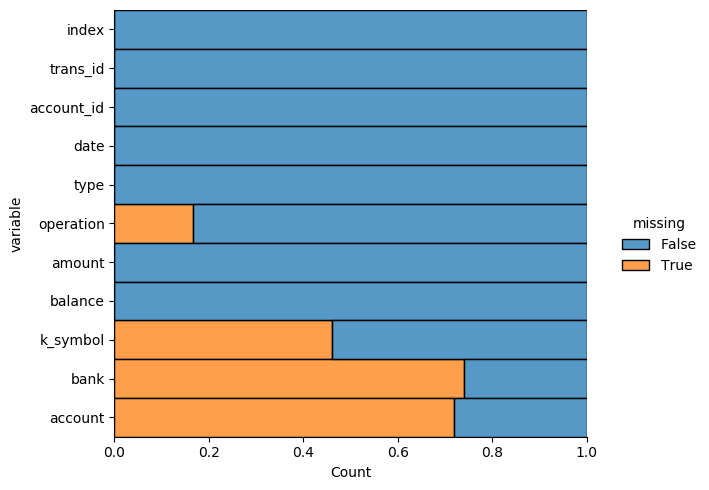

In [11]:
# heat map for missing values
plt.figure(figsize=(6,6))
sns.displot(
    data=trans_df.isna().melt(value_name="missing"),
    y="variable",
    hue="missing",
    multiple="fill",
    aspect=1.25
)
plt.show()

A heat map visualization of the missing values was produced. From this visualization, it is evident that the following rows will need to handled for missing values: operation, k_symbol, bank, account.

In [12]:
# data description
trans_df.describe()

,index,trans_id,account_id,amount,balance,account
count,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,2.953890e+05
mean,5.242870e+05,1.318043e+06,2.917406e+03,5.966699e+03,3.850006e+04,4.567092e+07
std,3.026977e+05,1.215395e+06,2.472923e+03,9.544910e+03,2.211196e+04,3.066340e+07
min,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,-4.112600e+04,0.000000e+00
25%,2.621435e+05,4.266925e+05,1.199000e+03,1.370000e+02,2.238900e+04,1.782858e+07
50%,5.242870e+05,8.525580e+05,2.423000e+03,2.126000e+03,3.311300e+04,4.575095e+07
75%,7.864305e+05,1.935710e+06,3.636000e+03,6.851000e+03,4.957300e+04,7.201341e+07
max,1.048574e+06,3.664355e+06,1.138200e+04,8.740000e+04,2.096370e+05,9.999420e+07


The .describe() function was used to generate a statistical summary for the numerical columns present within the data. Statistical measurements such as percentiles, mean, and standard deviation were included.

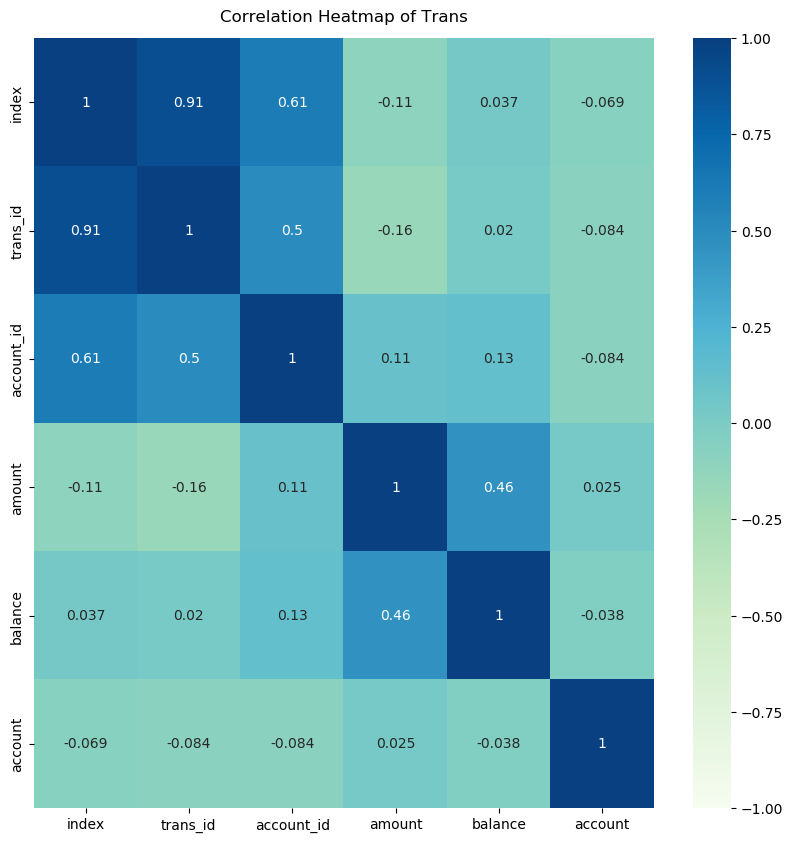

In [13]:
# correlation heatmap 
plt.figure(figsize=(10, 10))
heatmap = sns.heatmap(trans_df.corr(), vmin=-1, vmax=1, annot=True, cmap="GnBu")
heatmap.set_title('Correlation Heatmap of Trans', 
                  fontdict={'fontsize':12}, pad=12);
plt.show()

A correlation heatmap was produced in order to determine if there were any multicollinearity concerns. Looking at the correlation heat map, it is evident that there are some concerns of multicollinearity that will need to be addressed while pre-processing the data, as some of the correlation values are greater than 0.7. For example, index and trans_id are highly correlated with a pearson correlation value of 0.91.

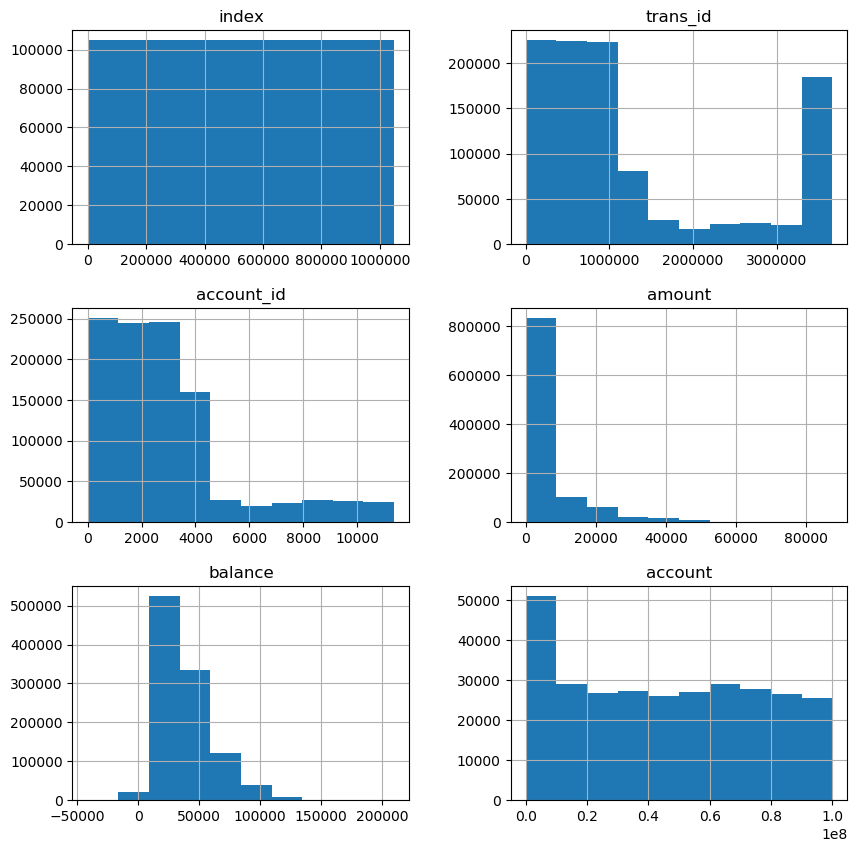

In [14]:
# histogram of numeric variables 
trans_df.hist(figsize=[10, 10])
plt.show()

Looking at the histograms above it is evident the variables account_id, amount, balance, and account are right skewed. This indicates that the mean values are greater than the median values resulting in the data being positively skewed. The index column is normally distributed and the trans_id column has a u-shaped distribution. Each of these distributions indicate that during the pre-processing normalization of the data through scaling and centering of the data should be considered.

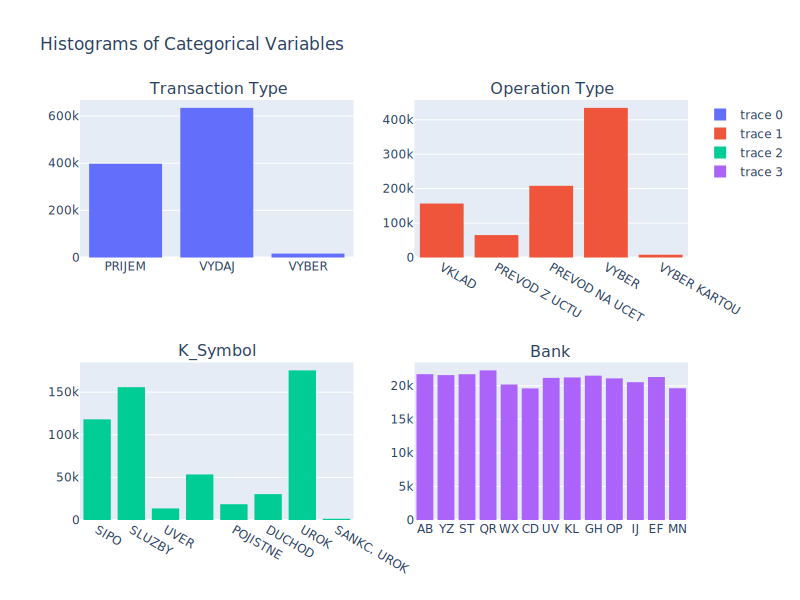

In [15]:
# bar graph of categorical variables 
fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=("Transaction Type", "Operation Type", "K_Symbol", 
                    "Bank"))

fig.add_trace(
    go.Histogram(x=trans_df['type']),
    row=1, col=1
)

fig.add_trace(
    go.Histogram(x=trans_df['operation']),
    row=1, col=2
)

fig.add_trace(
    go.Histogram(x=trans_df['k_symbol']),
    row=2, col=1
)

fig.add_trace(
    go.Histogram(x=trans_df['bank']),
    row=2, col=2
)

fig.update_layout(height=600, width=800, 
                  title_text="Histograms of Categorical Variables",
                  bargap=0.2)

fig.show()

Looking at the plot above it is evident that transaction type and operation type is slightly left skewed while bank is normally distributed. The variable k_symbol has a u-shaped distribution. The variables’ categories are in Czech and roughly translate to transaction types of credit card versus cash, and then under operation type it specifies further.

### Data 2: trans_2

In [16]:
# number of rows and columns
trans2_df.shape

(137326, 6)

The .shape() function was used in order to determine the number of rows and columns within this dataset. There are a total of 137,326 records and 6 columns.

In [17]:
# df info
trans2_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137326 entries, 0 to 137325
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   index           137326 non-null  int64 
 1   transaction_id  137326 non-null  int64 
 2   type            137326 non-null  object
 3   operation       137326 non-null  object
 4   amount2         137326 non-null  int64 
 5   balance         137326 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 6.3+ MB


The .info() function outputs an overview of the dataset. From this overview the following can be noted: column names, number of non-null present within the dataset, data type, number of the varying dtypes, and memory usage.

<Figure size 600x600 with 0 Axes>

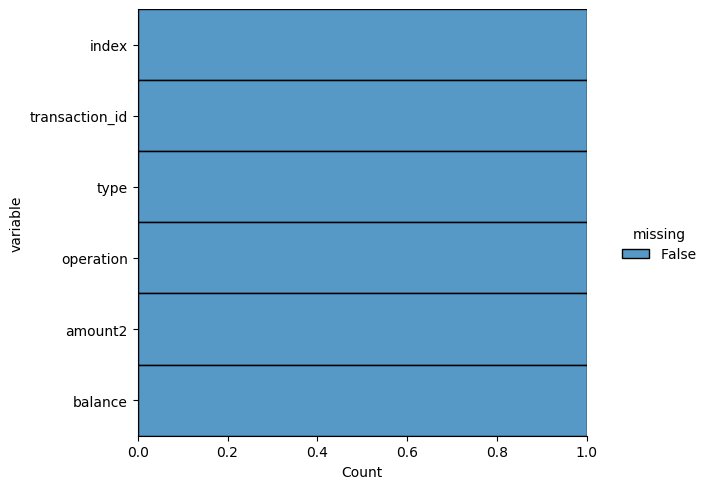

In [18]:
# heat map for missing values
plt.figure(figsize=(6,6))
sns.displot(
    data=trans2_df.isna().melt(value_name="missing"),
    y="variable",
    hue="missing",
    multiple="fill",
    aspect=1.25
)
plt.show()

A heat map visualization of the missing values was produced. From this visualization, it is evident that there are no missing values that need to be addressed while preprocessing the data.

In [19]:
# data description
trans2_df.describe()

,index,transaction_id,amount2,balance
count,137326.000000,1.373260e+05,137326.000000,137326.000000
mean,68662.500000,1.787270e+06,0.168431,0.369260
std,39642.745871,9.920609e+05,0.448134,0.536253
min,0.000000,2.890000e+02,0.000000,0.000000
25%,34331.250000,8.992222e+05,0.000000,0.000000
50%,68662.500000,1.779301e+06,0.000000,0.000000
75%,102993.750000,2.644035e+06,0.000000,1.000000
max,137325.000000,3.682967e+06,3.000000,3.000000


The .describe() function was used to generate a statistical summary for the numerical columns present within the data. Statistical measurements such as percentiles, mean, and standard deviation were included.

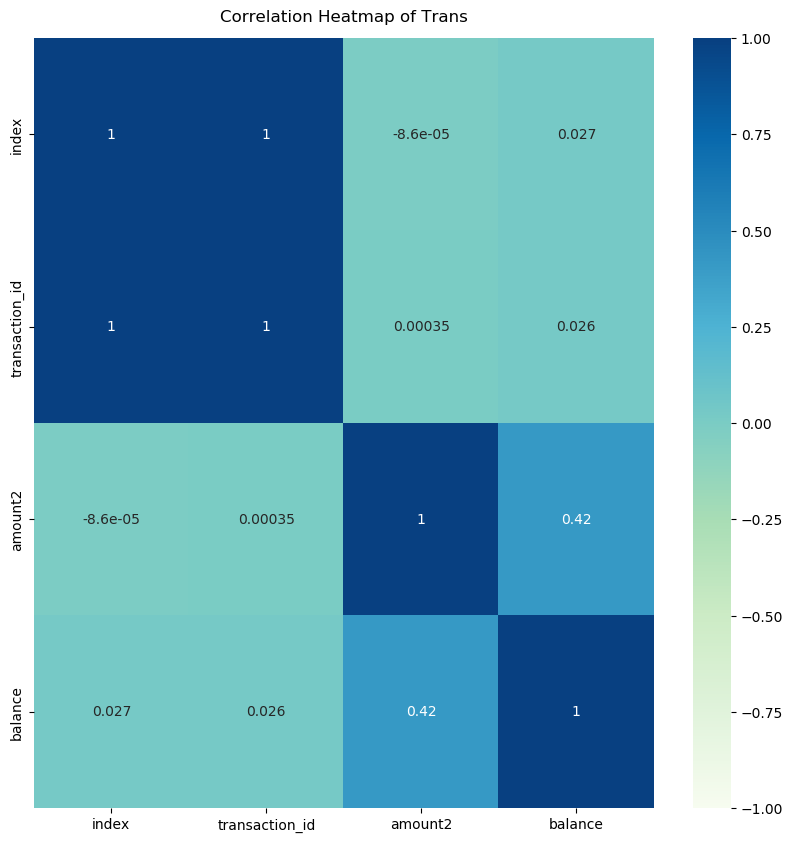

In [20]:
# correlation heatmap 
plt.figure(figsize=(10, 10))
heatmap = sns.heatmap(trans2_df.corr(), vmin=-1, vmax=1, annot=True, 
                      cmap="GnBu")
heatmap.set_title('Correlation Heatmap of Trans', 
                  fontdict={'fontsize':12}, pad=12);
plt.show()

A correlation heatmap was produced in order to determine if there were any multicollinearity concerns. Looking at the correlation heat map, it is evident that there are some concerns of multicollinearity that will need to be addressed while pre-processing the data, as some of the correlation values are greater than 0.7. For example, index and transaction_id are highly correlated with a pearson corrleation value of 1.0. 

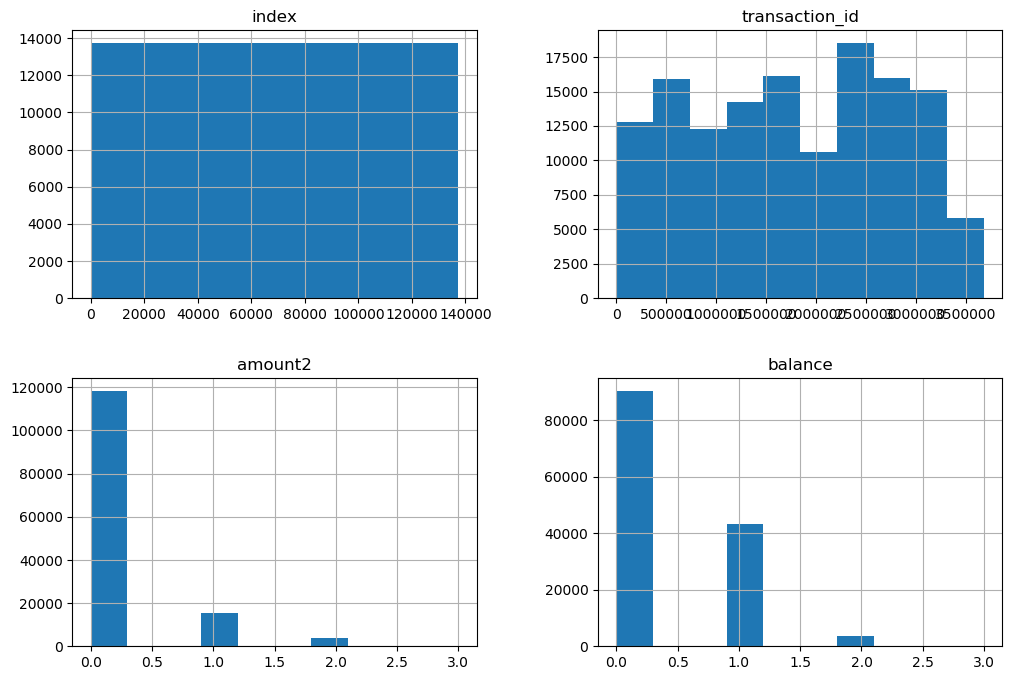

In [21]:
# histogram of numeric variables 
trans2_df.hist(figsize=[12, 8])
plt.show()

Looking at the histograms above, it is evident the variables amount2 and balance are right skewed. This indicates that the mean values are greater than the median values resulting in the data being positively skewed. The index column is normally distributed and the trans_id column has a u-shaped distribution. Each of these distributions indicate that during the pre-processing, normalization of the data through scaling and centering of the data should be considered.

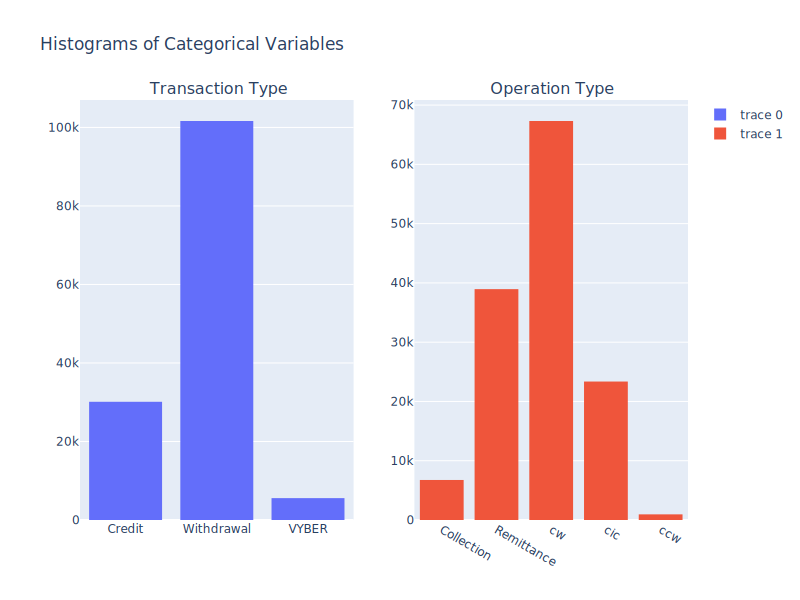

In [22]:
# bar graph of categorical variables 
fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=("Transaction Type", "Operation Type"))

fig.add_trace(
    go.Histogram(x=trans2_df['type']),
    row=1, col=1
)

fig.add_trace(
    go.Histogram(x=trans2_df['operation']),
    row=1, col=2
)
fig.update_layout(height=600, width=800, 
                  title_text="Histograms of Categorical Variables",
                  bargap=0.2)

fig.show()

### Data 3: loan 

In [23]:
# number of rows and columns
loan_df.shape

(682, 8)

The .shape() function was used in order to determine the number of rows and columns within this dataset. There are a total of 682 records and 8 columns.

In [24]:
# df info
loan_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 682 entries, 0 to 681
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   index       682 non-null    int64 
 1   loan_id     682 non-null    int64 
 2   account_id  682 non-null    int64 
 3   date        682 non-null    object
 4   amount      682 non-null    int64 
 5   duration    682 non-null    int64 
 6   payments    682 non-null    int64 
 7   status      682 non-null    object
dtypes: int64(6), object(2)
memory usage: 42.8+ KB


The .info() function outputs an overview of the dataset. From this overview, the following can be noted: column names, number of non-null present within the dataset, data type, number of the varying dtypes, and memory usage.

<Figure size 600x600 with 0 Axes>

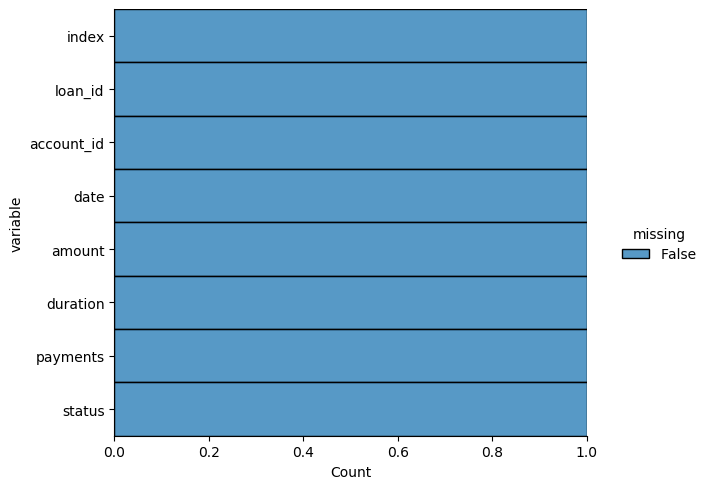

In [25]:
# heat map for missing values
plt.figure(figsize=(6,6))
sns.displot(
    data=loan_df.isna().melt(value_name="missing"),
    y="variable",
    hue="missing",
    multiple="fill",
    aspect=1.25
)
plt.show()

A heat map visualization of the missing values was produced. From this visualization, it is evident that there are no missing values that need to be addressed while preprocessing the data.

In [26]:
# data description
loan_df.describe()

,index,loan_id,account_id,amount,duration,payments
count,682.000000,682.000000,682.000000,682.000000,682.000000,682.000000
mean,340.500000,6172.466276,5824.162757,151410.175953,36.492669,4190.664223
std,197.020726,682.579279,3283.512681,113372.406310,17.075219,2215.830344
min,0.000000,4959.000000,2.000000,4980.000000,12.000000,304.000000
25%,170.250000,5577.500000,2967.000000,66732.000000,24.000000,2477.000000
50%,340.500000,6176.500000,5738.500000,116928.000000,36.000000,3934.000000
75%,510.750000,6752.500000,8686.000000,210654.000000,48.000000,5813.500000
max,681.000000,7308.000000,11362.000000,590820.000000,60.000000,9910.000000


The .describe() function was used to generate a statistical summary for the numerical columns present within the data. Statistical measurements such as percentiles, mean, and standard deviation were included.

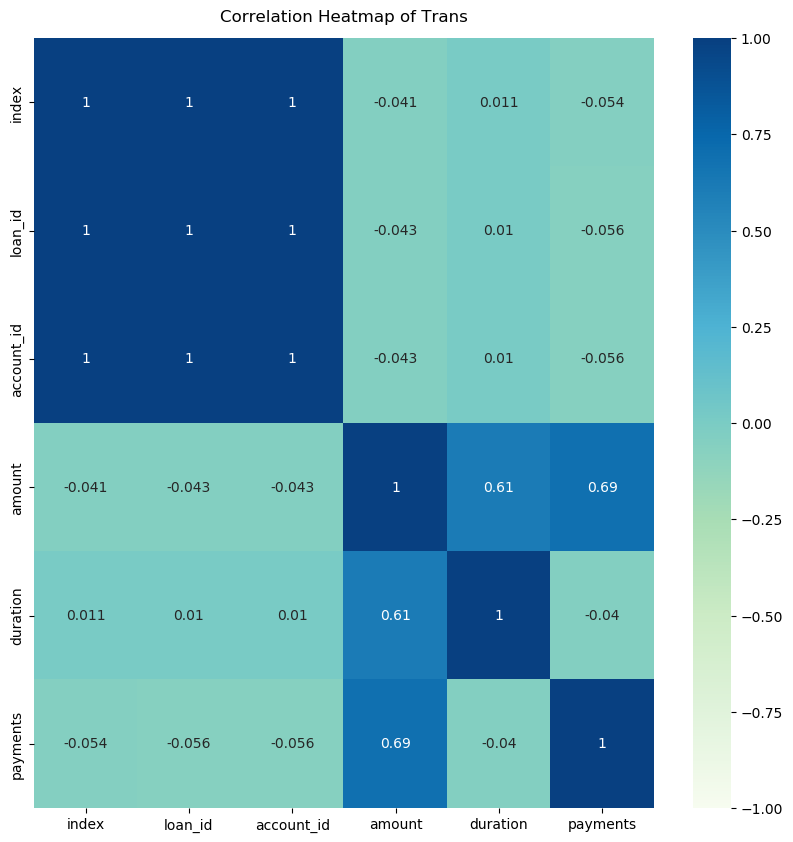

In [27]:
# correlation heatmap 
plt.figure(figsize=(10, 10))
heatmap = sns.heatmap(loan_df.corr(), vmin=-1, vmax=1, annot=True, cmap="GnBu")
heatmap.set_title('Correlation Heatmap of Trans', 
                  fontdict={'fontsize':12}, pad=12);
plt.show()

A correlation heatmap was produced in order to determine if there were any multicollinearity concerns. Looking at the correlation heat map, it is evident that there are some concerns of multicollinearity that will need to be addressed while pre-processing the data, as some of the correlation values are greater than 0.7. For example, index and loan_id are highly correlated with a pearson corrleation value of 1. 

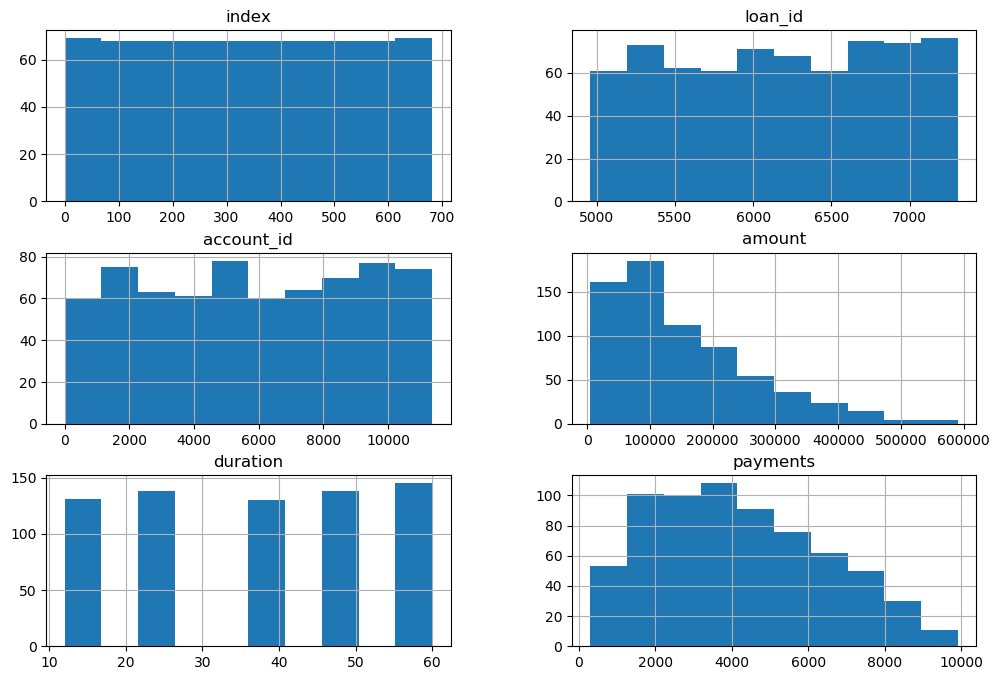

In [28]:
# histogram of numeric variables 
loan_df.hist(figsize=[12, 8])
plt.show()

Looking at the histograms above, it is evident the variable amounts and payments are right skewed. This indicates that the mean values are greater than the median values resulting in the data being positively skewed. The variables index, duration, account_id, and loan_id are normally distributed. Each of these distributions indicate that during the pre-processing, normalization of the data through scaling and centering of the data should be considered.

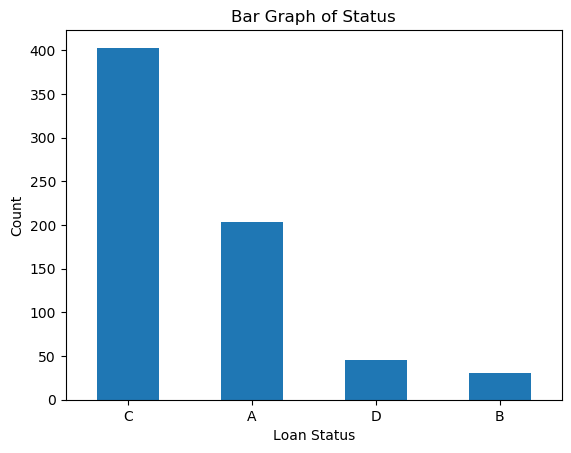

In [29]:
# bar graph of categorical variable
loan_df.status.value_counts().plot(kind="bar")
plt.title("Bar Graph of Status")
plt.xlabel("Loan Status")
plt.xticks(rotation=0)
plt.ylabel("Count")
plt.show()

The loan_status variable is our target variable. The status types C and A indicate a successful loan borrowing interaction, and D and B indicate an unsuccessful loan borrowing interaction. Looking at the bar plot above, it is evident that there is a class imbalance between the successful and unsuccessful loan borrowers. Based on this class imbalance, the data should most likely be split using a stratified approach along with the use of the resample function to mitigate the class imbalance.

### Data 4: account 

In [30]:
# number of rows and columns
account_df.shape

(4500, 5)

The .shape() function was used in order to determine the number of rows and columns within this dataset. There are a total of 4500 records and 5 columns.

In [31]:
# df info
account_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4500 entries, 0 to 4499
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   index        4500 non-null   int64 
 1   account_id   4500 non-null   int64 
 2   district_id  4500 non-null   int64 
 3   frequency    4500 non-null   object
 4   date         4500 non-null   object
dtypes: int64(3), object(2)
memory usage: 175.9+ KB


The .info() function outputs an overview of the dataset. From this overview, the following can be noted: column names, number of non-null present within the dataset, data type, number of the varying dtypes, and memory usage.

<Figure size 600x600 with 0 Axes>

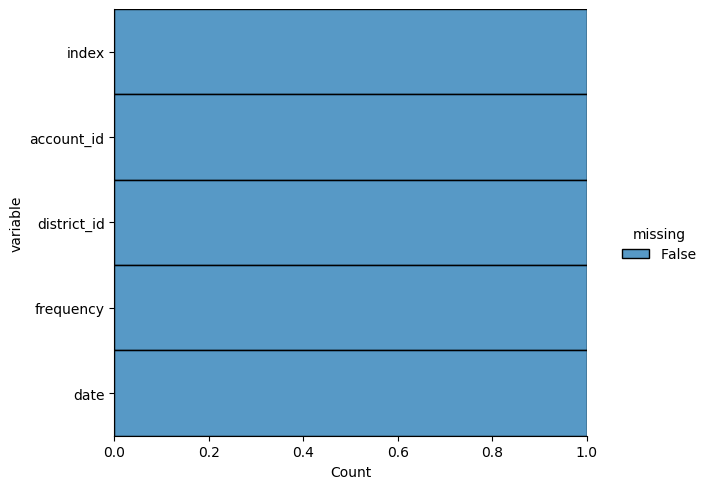

In [32]:
# heat map for missing values
plt.figure(figsize=(6,6))
sns.displot(
    data=account_df.isna().melt(value_name="missing"),
    y="variable",
    hue="missing",
    multiple="fill",
    aspect=1.25
)
plt.show()

A heat map visualization of the missing values was produced. From this visualization, it is evident that there are no missing values that need to be addressed while preprocessing the data.

In [33]:
# data description
account_df.describe()

,index,account_id,district_id
count,4500.000000,4500.000000,4500.000000
mean,2249.500000,2786.067556,37.310444
std,1299.182435,2313.811984,25.177217
min,0.000000,1.000000,1.000000
25%,1124.750000,1182.750000,13.000000
50%,2249.500000,2368.000000,38.000000
75%,3374.250000,3552.250000,60.000000
max,4499.000000,11382.000000,77.000000


The .describe() function was used to generate a statistical summary for the numerical columns present within the data. Statistical measurements such as percentiles, mean, and standard deviation were included.

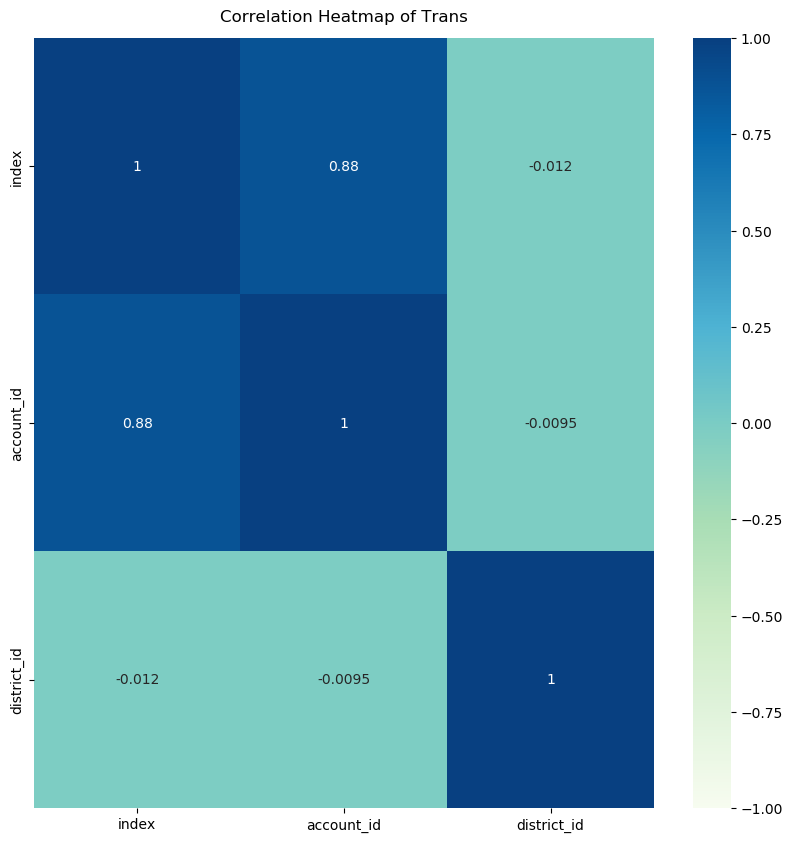

In [34]:
# correlation heatmap 
plt.figure(figsize=(10, 10))
heatmap = sns.heatmap(account_df.corr(), vmin=-1, vmax=1, annot=True, cmap="GnBu")
heatmap.set_title('Correlation Heatmap of Trans', 
                  fontdict={'fontsize':12}, pad=12);
plt.show()

A correlation heatmap was produced in order to determine if there were any multicollinearity concerns. Looking at the correlation heat map, it is evident that there are some concerns of multicollinearity that will need to be addressed while pre-processing the data, as some of the correlation values are greater than 0.7. For example, index and account_id are highly correlated with a pearson corrleation value of 0.88. 

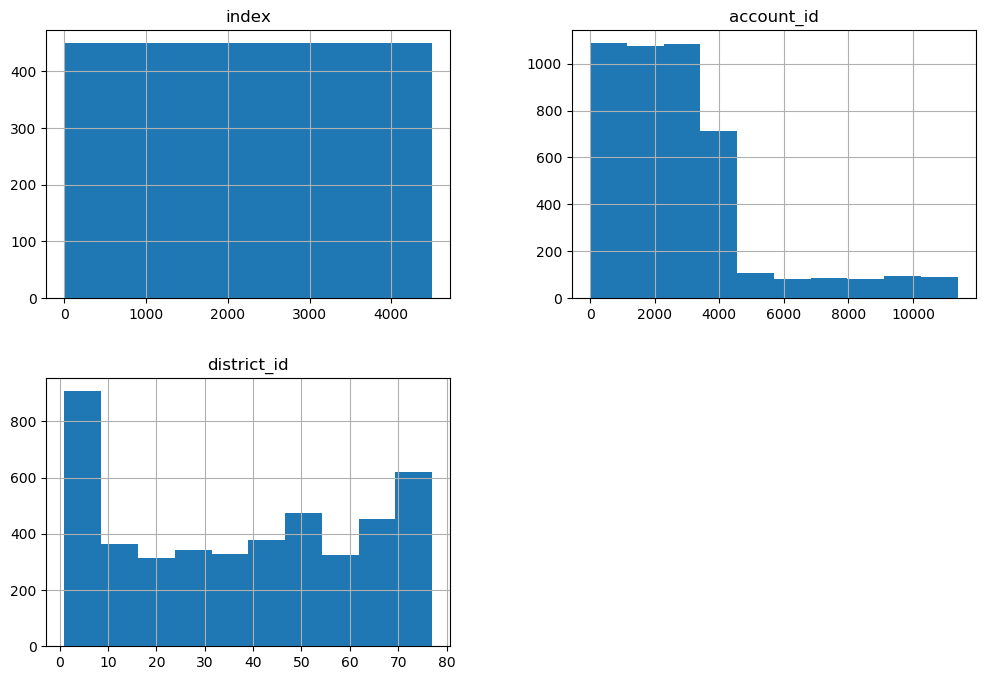

In [35]:
# histogram of numeric variables 
account_df.hist(figsize=[12, 8])
plt.show()

Looking at the histograms above, it is evident the variable account_id is right skewed. This indicates that the mean values are greater than the median values resulting in the data being positively skewed. The index column, and district_id are normally distributed. Each of these distributions indicate that during the pre-processing, normalization of the data through scaling and centering of the data should be considered.

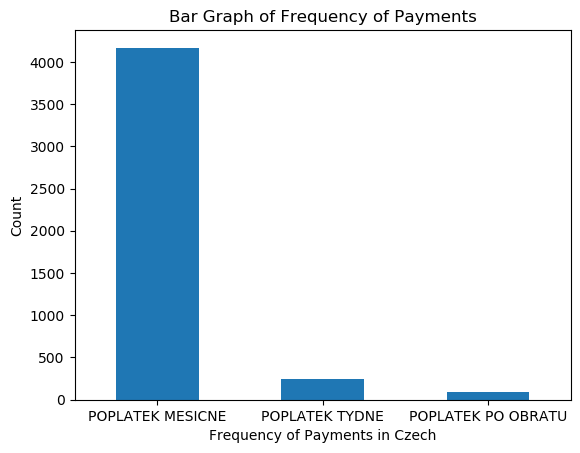

In [36]:
# bar graph of categorical variable
account_df.frequency.value_counts().plot(kind="bar")
plt.title("Bar Graph of Frequency of Payments")
plt.xlabel("Frequency of Payments in Czech")
plt.xticks(rotation=0)
plt.ylabel("Count")
plt.show()

This graph is heavily right skewed. Additionally, it should be noted that the frequency of payments are in Czech. The frequency of payments roughtly translates to monthly payments, weekly payments, and bimonthly payments. 

## Data Wrangling 

In [4]:
# database (db) set-up using athena 
sess = sagemaker.Session()
bucket = sess.default_bucket()
role = sagemaker.get_execution_role()
region = boto3.Session().region_name
ingest_create_athena_db_passed = False

In [5]:
# database (db) name set-up
db_name = "SDAloans"
# s3 staging directory 
s3_sg_dir = "s3://{0}/athena/staging".format(bucket)
# connection via directory for querying
conn = connect(region_name=region, s3_staging_dir=s3_sg_dir)

In [6]:
# creating the database (db = SDAloans)
statement = "CREATE DATABASE IF NOT EXISTS {}".format(db_name)
print(statement)
pd.read_sql(statement, conn)

CREATE DATABASE IF NOT EXISTS SDAloans


""


In [7]:
# verification of db creation
statement = "SHOW DATABASES"
df_show = pd.read_sql(statement, conn)
df_show.head(3)

,database_name
0,default
1,sdaloans


In [8]:
# setting directory to s3 bucket with files
# SDAloans_dir = 's3://ads508loanapproval/datasets/data1'

In [9]:
# SQL: reading in the 1st dataset=trans.csv as a table (tb) into directory
tb1_name ='trans'
pd.read_sql(f'DROP TABLE IF EXISTS {db_name}.{tb1_name}', conn)

create_table = f"""
CREATE EXTERNAL TABLE IF NOT EXISTS {db_name}.{tb1_name}(
                index int,
                trans_id int,
                account_id int,
                date date,
                type string,
                operation string,
                amount int,
                balance int,
                k_symbol string,
                bank string,
                account int
                )
                
                ROW FORMAT DELIMITED
                FIELDS TERMINATED BY ','
                LOCATION 's3://ads508loanapproval/datasets/data1/'
                TBLPROPERTIES ('skip.header.line.count'='1')
"""
pd.read_sql(create_table, conn)
pd.read_sql(f'SELECT * FROM {db_name}.{tb1_name} LIMIT 3', conn)

,index,trans_id,account_id,date,type,operation,amount,balance,k_symbol,bank,account
0,515583,839750,2859,None,VYDAJ,VYBER,3600,64639,,,None
1,515584,839751,2859,None,VYDAJ,VYBER,3900,26081,,,None
2,515585,839754,2859,None,VYDAJ,VYBER,6000,29981,,,None


In [10]:
# SQL: reading in the 2nd dataset=trans_2.csv as a table (tb) into directory
tb2_name ='trans_2'
pd.read_sql(f'DROP TABLE IF EXISTS {db_name}.{tb2_name}', conn)

create_table = f"""
CREATE EXTERNAL TABLE IF NOT EXISTS {db_name}.{tb2_name}(
                index int,
                trans_id int,
                type string,
                operation string,
                amount2 int,
                balance int
                )
                
                ROW FORMAT DELIMITED
                FIELDS TERMINATED BY ','
                LOCATION 's3://ads508loanapproval/datasets/data2/'
                TBLPROPERTIES ('skip.header.line.count'='1')
"""
pd.read_sql(create_table, conn)
pd.read_sql(f'SELECT * FROM {db_name}.{tb2_name} LIMIT 3', conn)

,index,trans_id,type,operation,amount2,balance
0,0,289,Credit,Collection,0,0
1,1,290,Credit,Collection,0,0
2,2,291,Credit,Collection,0,0


In [11]:
# SQL: reading in the 3rd dataset=loan.csv as a table (tb) into directory
tb3_name ='loan'
pd.read_sql(f'DROP TABLE IF EXISTS {db_name}.{tb3_name}', conn)

create_table = f"""
CREATE EXTERNAL TABLE IF NOT EXISTS {db_name}.{tb3_name}(
                index int,
                loan_id int,
                account_id int,
                date date,
                amount int,
                duration int,
                payments float,
                status string
                )
                
                ROW FORMAT DELIMITED
                FIELDS TERMINATED BY ','
                LOCATION 's3://ads508loanapproval/datasets/data3/'
                TBLPROPERTIES ('skip.header.line.count'='1')
"""
pd.read_sql(create_table, conn)
pd.read_sql(f'SELECT * FROM {db_name}.{tb3_name} LIMIT 3', conn)

,index,loan_id,account_id,date,amount,duration,payments,status
0,0,4959,2,None,80952,24,3373.0,A
1,1,4961,19,None,30276,12,2523.0,B
2,2,4962,25,None,30276,12,2523.0,A


In [12]:
# SQL: reading in the 4th dataset=account.csv as a table (tb) into directory
tb4_name ='account'
pd.read_sql(f'DROP TABLE IF EXISTS {db_name}.{tb4_name}', conn)

create_table = f"""
CREATE EXTERNAL TABLE IF NOT EXISTS {db_name}.{tb4_name}(
                index int,
                account_id int,
                district_id int,
                frequency string,
                date date
                )
                
                ROW FORMAT DELIMITED
                FIELDS TERMINATED BY ','
                LOCATION 's3://ads508loanapproval/datasets/data4/'
                TBLPROPERTIES ('skip.header.line.count'='1')
"""
pd.read_sql(create_table, conn)
pd.read_sql(f'SELECT * FROM {db_name}.{tb4_name} LIMIT 3', conn)

,index,account_id,district_id,frequency,date
0,0,1,18,POPLATEK MESICNE,None
1,1,2,1,POPLATEK MESICNE,None
2,2,3,5,POPLATEK MESICNE,None


In [13]:
# verification of db creation + storing 
statement = "SHOW DATABASES"
df_show = pd.read_sql(statement, conn)
df_show.head(3)

,database_name
0,default
1,sdaloans


In [14]:
if db_name in df_show.values:
    ingest_create_athena_db_passed = True

In [15]:
%store ingest_create_athena_db_passed

Stored 'ingest_create_athena_db_passed' (bool)


In [16]:
# SQL: merging tb 1-4 + saving as a df + renaming + removal of unnecessary attributes
df_i=pd.read_sql(f'SELECT * FROM (SELECT l.amount as loan_amt, l.duration,\
l.payments as pay_amt, l.status, a.frequency as pay_freq,\
t.amount as avg_pay_amt, t.balance, tr.operation FROM {db_name}.{tb3_name} as l\
 LEFT JOIN {db_name}.{tb4_name} as a\
 on l.account_id = a.account_id\
 LEFT JOIN {db_name}.{tb1_name} as t\
 on l.account_id = t.account_id\
 LEFT JOIN {db_name}.{tb2_name} as tr\
 on t.trans_id = tr.trans_id)', conn)

In [17]:
# check 
df_i.head(3)

,loan_amt,duration,pay_amt,status,pay_freq,avg_pay_amt,balance,operation
0,30276,12,2523.0,B,POPLATEK MESICNE,36,10840,None
1,30276,12,2523.0,B,POPLATEK MESICNE,5,8211,cw
2,30276,12,2523.0,B,POPLATEK MESICNE,35,8188,None


## Secondary Exploratory Data Analysis (EDA)

In [18]:
# df copy
df = df_i.copy()

Above is the creation of a copy of the original merged dataframe. This was done in order to ensure that while working an uneffected dataframe copy can be referred back to. 

In [52]:
# number of rows and columns
df.shape

(184356, 8)

In [53]:
# df info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 184356 entries, 0 to 184355
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   loan_amt     184356 non-null  int64  
 1   duration     184356 non-null  int64  
 2   pay_amt      184356 non-null  float64
 3   status       184356 non-null  object 
 4   pay_freq     184356 non-null  object 
 5   avg_pay_amt  184356 non-null  int64  
 6   balance      184356 non-null  int64  
 7   operation    137187 non-null  object 
dtypes: float64(1), int64(4), object(3)
memory usage: 11.3+ MB


<Figure size 300x300 with 0 Axes>

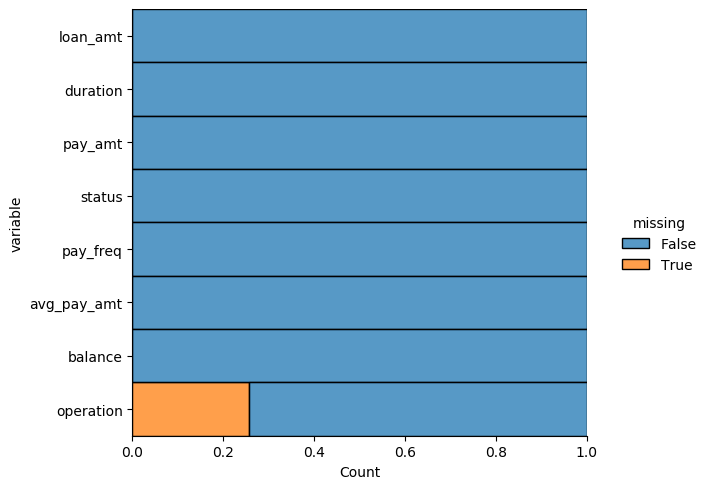

In [54]:
# heat map for missing values
plt.figure(figsize=(3,3))
sns.displot(
    data=df.isna().melt(value_name="missing"),
    y="variable",
    hue="missing",
    multiple="fill",
    aspect=1.25
)
plt.show()

In [55]:
# data description
df.describe()

,loan_amt,duration,pay_amt,avg_pay_amt,balance
count,184356.000000,184356.000000,184356.000000,184356.000000,184356.000000
mean,146592.543318,35.685804,4178.310459,8593.248389,45641.627335
std,110100.818539,17.216874,2207.773430,11912.346644,24980.558236
min,4980.000000,12.000000,304.000000,0.000000,-19310.000000
25%,65184.000000,24.000000,2477.000000,233.000000,27475.750000
50%,111384.000000,36.000000,3900.000000,3900.000000,41072.000000
75%,202848.000000,48.000000,5900.000000,11200.000000,59649.250000
max,590820.000000,60.000000,9910.000000,87300.000000,209637.000000


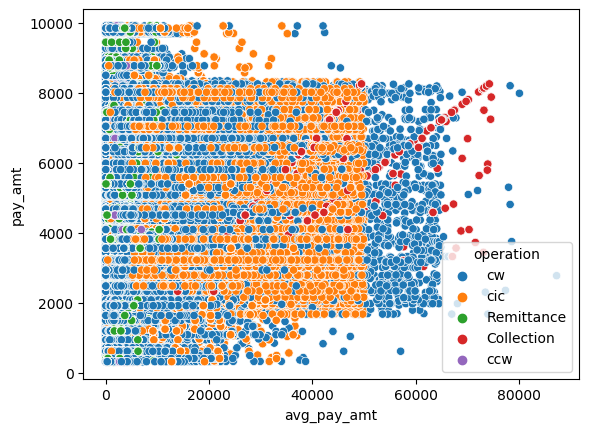

In [56]:
sns.scatterplot(data=df, x="avg_pay_amt", y="pay_amt", hue="operation")
plt.show()

From the plot above, it is evident that clients that that have paid, on average, 40000 dollars to 50000 dollars have made payments using credit card payments. The credit cards used to pay back the SDA bank are associated with another bank. It can also be noted that clientts that have paid, on average, 50000 dollars to 65000 dollars towards their loans have opted to use bank-to-bank transfers. 

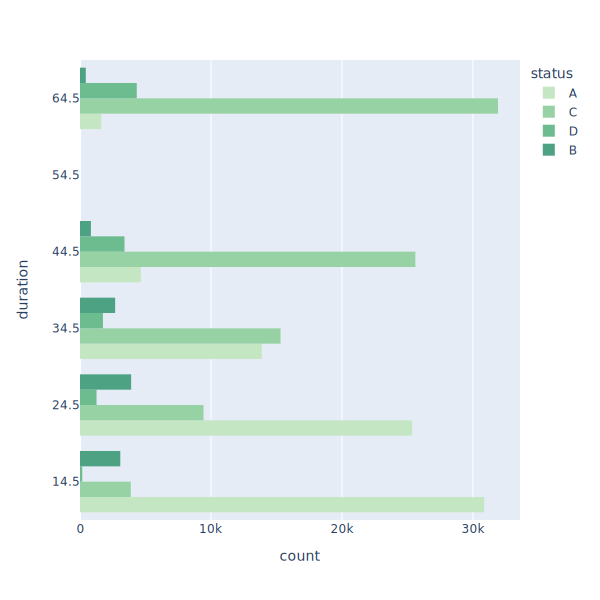

In [57]:
px.histogram(df, y='duration', color='status', 
            barmode = 'group', 
             color_discrete_sequence=px.colors.sequential.Blugrn,
            width=600, height =600)

Looking at the plot above, it is evident that the most amount of non recommendable clients are in the loan contracts that are shorter. For example, loans that are to be paid in approximately fifteen months have a higher level of non recommendable clients than loans that can be paid in sixty-four months. This may indicate that shorter loan duration contracts are of higher risk. Another thing to note is that regardless of the duration of the loan, most of the clients are in good standing with the SDA bank. 

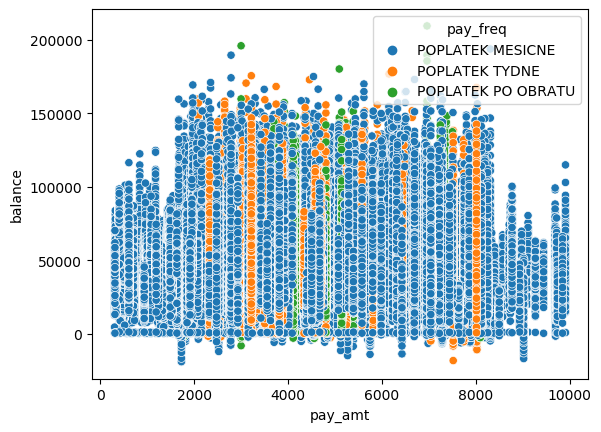

In [58]:
sns.scatterplot(data=df, x="pay_amt", y="balance", hue="pay_freq")
plt.show()

From the plot above, it is evident that the majority of clients, regardless of the amount of money that they borrowed, are required to make monthly payments towards their loans. 

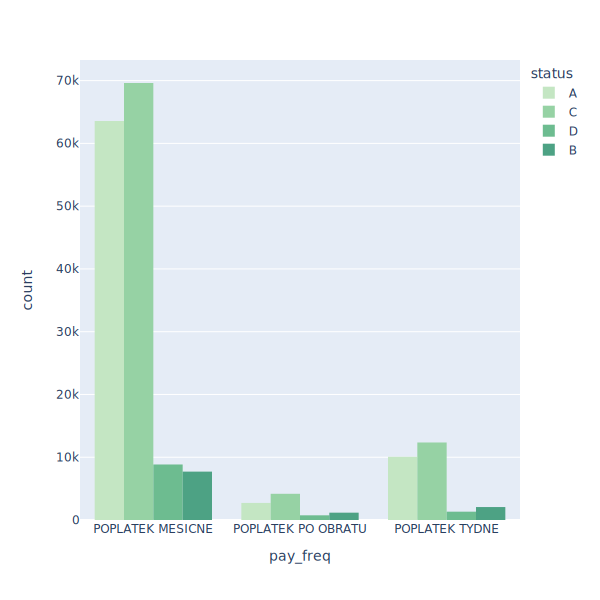

In [59]:
px.histogram(df, x='pay_freq', color='status', 
            barmode = 'group', 
             color_discrete_sequence=px.colors.sequential.Blugrn,
            width=600, height =600)

Looking at the plot above, it is evident that most of the clients, regardless of required payment frequency, are in good standing with the bank. It is evident, based on proportions, that those that are required to pay twice a month have the highest rate of non recommendable clients. This may indicate that payment contracts that reflect bimonthly payments are of high risk. Further analysis should be conducted in order to verify this conjecture. 

## Data Preparation

### Multicollinearity Checks + Corrections

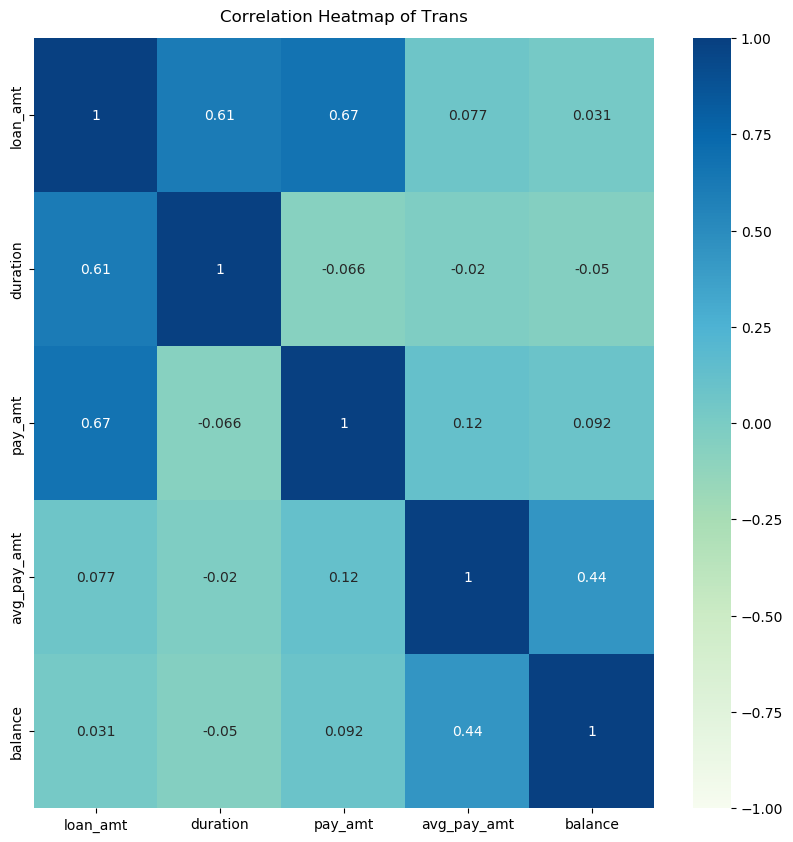

In [60]:
# correlation heat map to check for multicollinearity 
plt.figure(figsize=(10, 10))
heatmap = sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True, cmap="GnBu")
heatmap.set_title('Correlation Heatmap of Trans', 
                  fontdict={'fontsize':12}, pad=12);
plt.show()

No concerns of multicollinearity that need to be corrected for as none of the coefficients exceed 0.7. 

### Recoding of Categorical Data

In [28]:
# checking the values w/in the target var = status 
df = df_i.copy()
df.status.unique()

array(['B', 'A', 'D', 'C'], dtype=object)

In [29]:
# dummy coding the target variable "status" manually 
df['status'] = df['status'].map({'A': 1, 'B': 0,'C': 1,'D': 0}) 

# check
df.status.unique()

array([0, 1])

``` status ```: status of loan payment


*   'A': contract ended; loan paid
*   'B': contract ended; loan unpaid
*   'C': contract in progress; client on track to pay off loan
* 'D': contract in progress; client in debt


Based on these indicators of A, B, C, and D, it is evident that A and C indicate good loan candidates while B and D indicate poor loan candidates. The ``` status ``` column was therefore recoded to reflect this by indicating A and C as 1 and B and D as 0. 

In [38]:
# handling missing values 
df = df.dropna()

In [39]:
# dummy coding a predictor variable "operation" using one-hot-encoding
df_cat = pd.concat([df, pd.get_dummies(df['operation'], prefix='op')],axis=1)

In [40]:
# dummy coding a predictor variable "pay_freq" using one-hot-encoding
df_cat = pd.concat([df_cat, pd.get_dummies(df_cat['pay_freq'], prefix='pay')],axis=1)
# check
df_cat.head(2)

,loan_amt,duration,pay_amt,status,pay_freq,avg_pay_amt,balance,operation,op_Collection,op_Remittance,op_ccw,op_cic,op_cw,pay_POPLATEK MESICNE,pay_POPLATEK PO OBRATU,pay_POPLATEK TYDNE
1,30276,12,2523.0,0,POPLATEK MESICNE,5,8211,cw,0,0,0,0,1,1,0,0
4,30276,12,2523.0,0,POPLATEK MESICNE,7,7507,cw,0,0,0,0,1,1,0,0


In [41]:
# dropping "operation" and "payment_freq"
df_cat.drop(['operation', 'pay_freq'], axis=1, inplace = True)

# drop check 
print(df_cat.columns)

Index(['loan_amt', 'duration', 'pay_amt', 'status', 'avg_pay_amt', 'balance',
       'op_Collection', 'op_Remittance', 'op_ccw', 'op_cic', 'op_cw',
       'pay_POPLATEK MESICNE', 'pay_POPLATEK PO OBRATU', 'pay_POPLATEK TYDNE'],
      dtype='object')


In [42]:
# correcting column names 
df_cat.rename(columns = {'op_Collection':'op_cb', 
                         'op_Remittance':'op_cp',
                         'op_ccw':'op_ccp',
                        'op_cic':'op_ccb',
                        'op_cw':'op_bb',
                        'pay_POPLATEK MESICNE':'pay_mo',
                        'pay_POPLATEK PO OBRATU':'pay_bimo',
                        'pay_POPLATEK TYDNE':'pay_wk'}, inplace = True)
# renaming check
print(df_cat.columns)

Index(['loan_amt', 'duration', 'pay_amt', 'status', 'avg_pay_amt', 'balance',
       'op_cb', 'op_cp', 'op_ccp', 'op_ccb', 'op_bb', 'pay_mo', 'pay_bimo',
       'pay_wk'],
      dtype='object')


### Bias Detection 

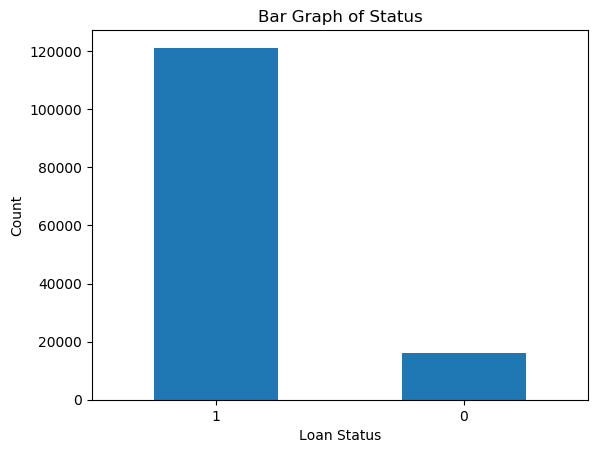

In [43]:
# visualization of target variable status 
df_cat.status.value_counts().plot(kind="bar")
plt.title("Bar Graph of Status")
plt.xlabel("Loan Status")
plt.xticks(rotation=0)
plt.ylabel("Count")
plt.show()

Looking at the bar chart above, it is evident that there is the bias of class imbalnce present within this dataset. This is the case as the two outcomes are clearly unbalanced. The way in which this could be handled is through oversampling the minority group or undersampling the majoirity group.

### Mitigation of Class Imbalance 

For the purpose of this project, the way in which class imbalance was chosen to be handeled was through oversampling the minority class. Oversampling can aid with creating a more balanced dataset so that the results of the model predictions are more accurate. Essentially, oversampling was chosen over undersampling as oversampling will ensure that no information is lost. The technique of using the RandomOverSampler function over other oversampling techniques such as SMOTE oversmapling is because it is considered more roboust in terms of model results than SMOTE oversampling (Chadha, 2022).

In [44]:
# oversampling miniority class to handle the imbalance 
oversample = RandomOverSampler(sampling_strategy='minority')
col = "status"
x = df_cat.loc[:, df_cat.columns !=col]
y = df_cat["status"]
x_over, y_over = oversample.fit_resample(x,y)
df_cat2 = pd.concat([pd.DataFrame(x_over), 
                 pd.DataFrame(y_over)], axis=1)
df_cat2.columns = df_cat.columns

In [45]:
# oversampling + rebalancing check 
z_ct = df_cat2['status'].value_counts()[0]
o_ct = df_cat2['status'].value_counts()[1]
z_o = z_ct + o_ct
z_ct1 = df_cat['status'].value_counts()[0]
o_ct1 = df_cat['status'].value_counts()[1]
z_o1 = z_ct1 + o_ct1
print('Nonrecommendable Loan Candidates(%) before Oversampling:', round(z_ct1/z_o1,2))
print('Recommendable Loan Candidates(%) before Oversampling:', round(o_ct1/z_o1,2))
print('Nonrecommendable Loan Candidates(%) after Oversampling:', round(z_ct/z_o,2))
print('Recommendable Loan Candidates(%) after Oversampling:', round(o_ct/z_o,2))

Nonrecommendable Loan Candidates(%) before Oversampling: 0.12
Recommendable Loan Candidates(%) before Oversampling: 0.88
Nonrecommendable Loan Candidates(%) after Oversampling: 0.42
Recommendable Loan Candidates(%) after Oversampling: 0.58


Looking at the results above based on the RandomOverSampler, oversampling technique, it is evident that the oversampling technique really helped balance out the dataset. Initially, the data was drastically imbalanced with 12:88 percent non recommendable to recommendable loan candidates distribution within the dataset. Now, after oversampling, there is a 42:58 percent non recommendable to recommendable loan candidate distribution within the dataset. 

### Columns: 
- ```loan_amt:``` amount of money borrowed from the bank 
- ```  duration: ``` contract-based time allotment in which the loan is expected to be paid
- ```  pay_amt: ``` amount to be paid to the bank each month, week, or twice a month
- ```  status: ``` loan status (completed: paid or debt, in-progress: paid or debt)
- ```  pay_mo: ``` indicates if the client if required to pay once a month 
- ```  pay_wk: ``` indicates if the client is required to pay once a week 
- ```  pay_bimo: ``` indicates if the client is required to pay twice a month 
- ```  avg_pay_amt: ``` average amount of money paid by client 
- ```  balance: ``` loan balance 
- ```  op_ccp: ``` credit card payment
- ```  op_cp: ``` cash payment 
- ```  op_ccb: ``` credit card payment through another bank 
- ```  op_cb: ``` cash payment through another bank 
- ```  op_bb: ``` bank to bank transfer 

### Data Splitting 

In [48]:
# splitting data into train, test, and validation sets
df3, df4 = train_test_split(df_cat, train_size = 67854, random_state = 902)
x_train, y_train, x_valid, y_valid, x_test, y_test = train_valid_test_split(
    df3, target = 'status', train_size=0.7, valid_size=0.15, test_size=0.15
)

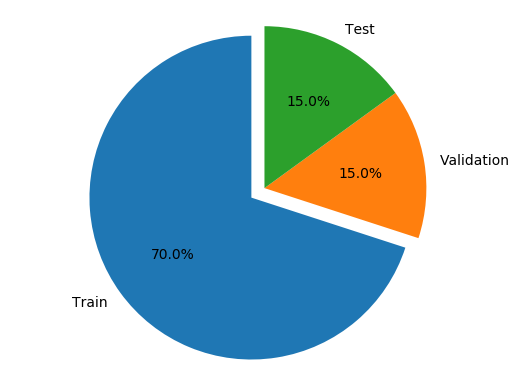

In [49]:
# pie visualization of splits 
labels = ["Train", "Validation", "Test"]
sizes = [len(x_train.index), len(x_valid.index), len(x_test.index)]
exp = (0.1, 0, 0)
fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=exp, labels=labels, autopct="%1.1f%%", startangle=90)
ax1.axis("equal")
plt.show()

In [50]:
# checking dimensions 
print('x_train:', x_train.shape, 'y_train:', y_train.shape)
print('x_valid:', x_valid.shape, 'y_valid:', y_valid.shape)
print('x_test:', x_test.shape, 'y_test:', y_test.shape)

x_train: (47497, 13) y_train: (47497,)
x_valid: (10178, 13) y_valid: (10178,)
x_test: (10179, 13) y_test: (10179,)


In [51]:
# normalizing numeric data based on the train
scaler = preprocessing.StandardScaler()
scaler.fit_transform(df_cat2[['loan_amt', 'duration', 'pay_amt', 'avg_pay_amt', 'balance']])

# combining the normalized values to the origional dataframe 
tNorm = pd.concat([pd.DataFrame(scaler.fit_transform(df_cat2[['loan_amt','duration','pay_amt','avg_pay_amt','balance']]),
                                columns=['z_loan_amt','z_duration', 'z_pay_amt','z_avg_pay_amt','z_balance']),
                   df_cat2[['pay_mo', 'pay_wk', 'pay_bimo', 'op_ccp', 'op_cp', 'op_ccb',
                          'op_cb', 'op_bb']]], axis = 1)

# setting the normalized values to the train, valid and test sets 
trainNorm = tNorm.iloc[x_train.index]
validNorm = tNorm.iloc[x_valid.index]
testNorm = tNorm.iloc[x_test.index]

In [52]:
# double checking dimensions 
print('x_train:', x_train.shape, 'y_train:', y_train.shape)
print('x_valid:', x_valid.shape, 'y_valid:', y_valid.shape)
print('x_test:', x_test.shape, 'y_test:', y_test.shape)

x_train: (47497, 13) y_train: (47497,)
x_valid: (10178, 13) y_valid: (10178,)
x_test: (10179, 13) y_test: (10179,)


## Modeling 

### Models 

In [44]:
# Random Forest Model 
rf = RandomForestClassifier(max_depth=2, random_state=902)
rf.fit(x_train, y_train)

RandomForestClassifier(max_depth=2, random_state=902)

In [45]:
# Random Forest Model Prediction on Validation Set 
rf_pred = rf.predict(x_valid)

In [47]:
# Naive Bayes Model 
nb = GaussianNB()
nb.fit(x_train, y_train)

GaussianNB()

In [48]:
# Naive Bayes Model Prediction on Validation Set 
nb_pred = nb.predict(x_valid)

In [50]:
# K-Nearest Neighbor (KNN)  Model 
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(x_train, y_train)

KNeighborsClassifier()

In [51]:
# KNN Model Prediction on Validation Set 
knn_pred = knn.predict(x_valid)

In [54]:
# Logistic Regression Model 
log = LogisticRegression(random_state=902)
log.fit(x_train, y_train)

LogisticRegression(random_state=902)

In [55]:
# Logistic Regression Model Prediction on Validation Set
log_pred = log.predict(x_valid)

### Model Evaluations & Comparisons 

In [56]:
# Random Forest Model Evals 
print(accuracy_score(y_valid, rf_pred))
print('Classification Report \n', 
       classification_report(y_valid, rf_pred))

0.8848496757712714
Classification Report 
               precision    recall  f1-score   support

           0       1.00      0.01      0.01      1180
           1       0.88      1.00      0.94      8998

    accuracy                           0.88     10178
   macro avg       0.94      0.50      0.48     10178
weighted avg       0.90      0.88      0.83     10178



In [57]:
# Naive Bayes Model Evals - Confusion Matrix 
print(accuracy_score(y_valid, nb_pred))
print('Classification Report \n', 
       classification_report(y_valid, nb_pred))

0.8665749656121046
Classification Report 
               precision    recall  f1-score   support

           0       0.33      0.14      0.20      1180
           1       0.90      0.96      0.93      8998

    accuracy                           0.87     10178
   macro avg       0.61      0.55      0.56     10178
weighted avg       0.83      0.87      0.84     10178



In [64]:
# KNN Model Evals - Confusion Matrix 
print(accuracy_score(y_valid, knn_pred))
print('Classification Report \n', 
       classification_report(y_valid, knn_pred))

0.9191393201021811
Classification Report 
               precision    recall  f1-score   support

           0       0.72      0.49      0.58      1180
           1       0.94      0.98      0.96      8998

    accuracy                           0.92     10178
   macro avg       0.83      0.73      0.77     10178
weighted avg       0.91      0.92      0.91     10178



In [59]:
# Logistic Regression Model Evals - Confusion Matrix 
print(accuracy_score(y_valid, log_pred))
print('Classification Report \n', 
       classification_report(y_valid, log_pred))

0.8852426802908233
Classification Report 
               precision    recall  f1-score   support

           0       0.54      0.07      0.12      1180
           1       0.89      0.99      0.94      8998

    accuracy                           0.89     10178
   macro avg       0.72      0.53      0.53     10178
weighted avg       0.85      0.89      0.84     10178



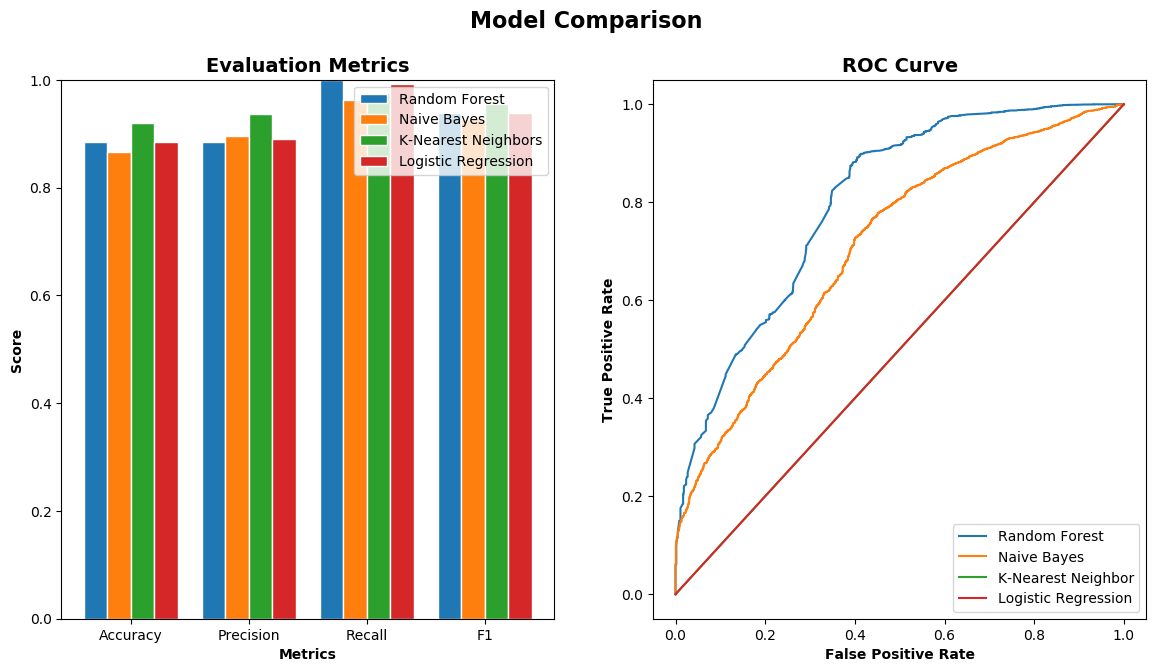

In [60]:
# Random Forest, Naive Bayes, and KNN Model Comparisons 
fig, (ax1, ax2) = plt.subplots(1, 2) # setting up the two plots 
fig.suptitle('Model Comparison', fontsize=16, fontweight='bold')
fig.set_figheight(7)
fig.set_figwidth(14)
fig.set_facecolor('white')

barWidth = 0.2 # plot 1 = metric comparison 
rf_score = [accuracy_score(y_valid,rf_pred), precision_score(y_valid, rf_pred), recall_score(y_valid, 
                                                                                             rf_pred), f1_score(y_valid, rf_pred)]
nb_score = [accuracy_score(y_valid,nb_pred), precision_score(y_valid, nb_pred), recall_score(y_valid, 
                                                                                             nb_pred), f1_score(y_valid, nb_pred)]
knn_score = [accuracy_score(y_valid,knn_pred), precision_score(y_valid, knn_pred), recall_score(y_valid, 
                                                                                             knn_pred), f1_score(y_valid, knn_pred)]
log_score = [accuracy_score(y_valid,log_pred), precision_score(y_valid, log_pred), recall_score(y_valid, 
                                                                                             log_pred), f1_score(y_valid, log_pred)]

r1 = np.arange(len(rf_score)) # bar set-up on x-axis 
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]

ax1.bar(r1, rf_score, width=barWidth, edgecolor='white', label='Random Forest') # plot 1 
ax1.bar(r2, nb_score, width=barWidth, edgecolor='white', label='Naive Bayes')
ax1.bar(r3, knn_score, width=barWidth, edgecolor='white', label='K-Nearest Neighbors')
ax1.bar(r4, log_score, width=barWidth, edgecolor='white', label='Logistic Regression')

ax1.set_xlabel('Metrics', fontweight='bold') # x/y-axis set-up 
labels = ['Accuracy', 'Precision', 'Recall', 'F1']
ax1.set_xticks([r + (barWidth * 1.5) for r in range(len(rf_score))], )
ax1.set_xticklabels(labels)
ax1.set_ylabel('Score', fontweight='bold')
ax1.set_ylim(0, 1)

ax1.set_title('Evaluation Metrics', fontsize=14, fontweight='bold') # title/legend 
ax1.legend()

y_pred_proba = rf.predict_proba(x_valid)[::,1] # random forest 
fpr, tpr, _ = metrics.roc_curve(y_valid,  y_pred_proba)
ax2.plot(fpr, tpr, label='Random Forest')
y_pred_proba1 = nb.predict_proba(x_valid)[::,1] # naive bayes 
fpr1, tpr1, _ = metrics.roc_curve(y_valid,  y_pred_proba1)
ax2.plot(fpr1, tpr1, label='Naive Bayes')
y_pred_proba2 = knn.predict_proba(x_valid)[::,1] # knn
fpr2, tpr2, _ = metrics.roc_curve(y_valid,  y_pred_proba2)
ax2.plot(fpr2, fpr2, label='K-Nearest Neighbor')
y_pred_proba5 = log.predict_proba(x_valid)[::,1] # logistic regression 
fpr5, tpr5, _ = metrics.roc_curve(y_valid,  y_pred_proba5)
ax2.plot(fpr5, fpr5, label='Logistic Regression')

ax2.set_xlabel('False Positive Rate', fontweight='bold')
ax2.set_ylabel('True Positive Rate', fontweight='bold')

ax2.set_title('ROC Curve', fontsize=14, fontweight='bold')
ax2.legend(loc=4)
plt.show()

### Amazon SageMaker: Built-In XGBoost Model 

In [115]:
role = sagemaker.get_execution_role()
my_region = boto3.session.Session().region_name # instance's region 
xgboost_container = sagemaker.image_uris.retrieve("xgboost", # XGBoost Container
                                                  my_region, 
                                                  "latest")

INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.


In [157]:
train, test = np.split(df3.sample(frac=1, random_state=902), 
                                 [int(0.7 * len(df3))])
print(train.shape, test.shape)

(47497, 14) (20357, 14)


In [158]:
train["status"] = pd.to_numeric(train["status"])

In [159]:
train = train.apply(lambda x: pd.factorize(x)[0])

In [160]:
train.to_csv("train.csv", header = False, index=False)

In [161]:
train.dtypes

loan_amt       int64
duration       int64
pay_amt        int64
status         int64
avg_pay_amt    int64
balance        int64
op_cb          int64
op_cp          int64
op_ccp         int64
op_ccb         int64
op_bb          int64
pay_mo         int64
pay_bimo       int64
pay_wk         int64
dtype: object

In [162]:
# rearranging columns w/status first b/c otherwise issues arise for the XGBoost training 
train = train[['status','loan_amt', 'duration', 'pay_amt', 'avg_pay_amt', 'balance',
       'op_cb', 'op_cp', 'op_ccp', 'op_ccb', 'op_bb', 'pay_mo', 'pay_bimo',
       'pay_wk']]

In [165]:
# bucketing training data to S3 bucket 
#s3 = boto3.resource('s3')
#s3.meta.client.upload_file("train.csv", 'ads508loanapproval', 'train')

In [175]:
# bucketing training data to s3
s3_client = boto3.client("s3")
BUCKET='ads508loanapproval'
KEY='train'
response = s3_client.get_object(Bucket=BUCKET, Key=KEY)

with io.StringIO() as csv_buffer:
    train.to_csv(csv_buffer, index=False, header=False)

    response = s3_client.put_object(
        Bucket=BUCKET, Key=KEY, Body=csv_buffer.getvalue()
    )

In [166]:
# adding training params 
s3_input_train = sagemaker.inputs.TrainingInput(s3_data=\
        's3://{}/train'.format(BUCKET), content_type='csv')

In [176]:
# sagemaker sess + instance setting 
sess = sagemaker.Session()
xgb = sagemaker.estimator.Estimator(xgboost_container,role, 
                                    instance_count=1, 
                                    instance_type='ml.m5.large',
                                    output_path='s3://{}/output'.format(BUCKET),
                                    sagemaker_session=sess)
# hyperparameter settings 
xgb.set_hyperparameters(max_depth=5,eta=0.2,gamma=4,min_child_weight=6,
                        subsample=0.8,silent=0,
                        objective='binary:logistic',num_round=100)

In [177]:
# model training 
xgb.fit({'train': s3_input_train})

INFO:sagemaker:Creating training-job with name: xgboost-2023-04-02-18-57-51-613


2023-04-02 18:57:52 Starting - Starting the training job...
2023-04-02 18:58:07 Starting - Preparing the instances for training...
2023-04-02 18:58:57 Downloading - Downloading input data......
2023-04-02 18:59:37 Training - Downloading the training image...
2023-04-02 19:00:23 Uploading - Uploading generated training modelArguments: train
[2023-04-02:19:00:18:INFO] Running standalone xgboost training.
[2023-04-02:19:00:18:INFO] Path /opt/ml/input/data/validation does not exist!
[2023-04-02:19:00:18:INFO] File size need to be processed in the node: 1.69mb. Available memory size in the node: 306.05mb
[2023-04-02:19:00:18:INFO] Determined delimiter of CSV input is ','
[19:00:18] S3DistributionType set as FullyReplicated
[19:00:18] 47497x13 matrix with 617461 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[19:00:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=5
[0]#011train-error:0.100764
[19:00:18]

In [179]:
# setting the predictions 
xgb_predictor = xgb.deploy(initial_instance_count=1,
                           instance_type='ml.m5.large')

INFO:sagemaker:Creating model with name: xgboost-2023-04-02-19-03-35-209
INFO:sagemaker:Creating endpoint-config with name xgboost-2023-04-02-19-03-35-209
INFO:sagemaker:Creating endpoint with name xgboost-2023-04-02-19-03-35-209


----!

In [180]:
# running the set predictions 
test_array = test.drop(['status'], axis=1).values

# setting serializer type 
xgb_predictor.serializer = CSVSerializer() 
predi = xgb_predictor.predict(test_array).decode('utf-8')

# setting data as array 
predi_array = np.fromstring(predi[1:], sep=',') 
print(predi_array.shape)

(20357,)


In [192]:
test.shape

(20357, 14)

In [224]:
# XGBoost Model Eval 
cm = pd.crosstab(index=test["status"], 
                 columns=np.round(predi_array), 
                 rownames=['Observed'], 
                 colnames=['Predicted'])
tn = cm.iloc[0,0]
fn = cm.iloc[1,0]
fp = cm.iloc[0,0]
tp = cm.iloc[1,0]


print("Precision", tp/(tp+fp)*100)
print("Sensitivity", tp/(tp+fn)*100)
print("Recall", tn/(tn+fp)*100)
print("Accuracy", (tp+tn)/(tp+fn+tn+fp)*100)

Precision 88.24974210345336
Sensitivity 50.0
Recall 50.0
Accuracy 50.0


In [225]:
# deleteting endpoint
xgb_predictor.delete_endpoint(delete_endpoint_config=True)

INFO:sagemaker:Deleting endpoint configuration with name: xgboost-2023-04-02-19-03-35-209
INFO:sagemaker:Deleting endpoint with name: xgboost-2023-04-02-19-03-35-209


## Resources

Chadha, A. S. (2022, January 6). Handling Imbalanced Datasets With Oversampling Techniques. It’s Pros & Cons. Medium. 
https://medium.com/analytics-vidhya/handling-imbalanced-datasets-with-oversampling-techniques-its-pros-cons-ba9f36ac5b71

Financial Dataset. (n.d.). CTU Prague Relational Learning Repository. https://relational.fit.cvut.cz/dataset/Financial

How XGBoost Works - Amazon SageMaker. (n.d.). 
https://docs.aws.amazon.com/sagemaker/latest/dg/xgboost-HowItWorks.html

Logistic Regression Model Explained - AWS. (n.d.). Amazon Web Services, Inc. 
https://aws.amazon.com/what-is/logistic-regression/#:~:text=Logistic%20regression%20is%20a%20data,outcomes%2C%20like%20yes%20or%20no.

Radha, S. E. (2023, March 24). Understand Random Forest Algorithms With Examples (Updated 2023). Analytics Vidhya.https://www.analyticsvidhya.com/blog/2021/06/understanding-random-forest/

Vatsal, V. (2022, May 20). K Nearest Neighbours Explained - Towards Data Science. Medium. https://towardsdatascience.com/k-nearest-neighbours-explained-7c49853633b6

Yıldırım, S. (2021, December 13). Naive Bayes Classifier — Explained - Towards Data Science. Medium. https://towardsdatascience.com/naive-bayes-classifier-explained-50f9723571ed
